This version builds on version 2, but this one actually has the correct risk equation, however that causes it to go to infinity without warning.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [2]:
def standardize_cols(X):
    zscore = lambda x: (x.mean() - x)/x.std()
    return pd.DataFrame(X).apply(zscore).values

def binarize_cols(X):
    temp = X.copy()
    temp[temp > 0] = 1
    temp[temp <= 0] = 0
    return temp

In [3]:
spam_data = scipy.io.loadmat("data/spam.mat")
Xraw = pd.DataFrame(spam_data['Xtrain'])
y = spam_data['Ytrain'].reshape((3450,))
Xtestraw = pd.DataFrame(spam_data['Xtest'])
print(Xraw.shape, y.shape, Xtestraw.shape)

stan_X = pd.DataFrame(standardize_cols(Xraw.values))
log_X = pd.DataFrame(np.log(Xraw.values + 0.1))
bin_X = pd.DataFrame(binarize_cols(Xraw.values))
stan_X[57] = 1
log_X[57] = 1
bin_X[57] = 1
Xraw[57] = 1
X = Xraw.values
stan_X = stan_X.values
log_X = log_X.values
bin_X = bin_X.values
print(X.shape, stan_X.shape, log_X.shape, bin_X.shape)

(3450, 57) (3450,) (1151, 57)
(3450, 58) (3450, 58) (3450, 58) (3450, 58)


In [141]:
def qkrsgd_test(vX, vy, tX, alpha):
    val_risk = []
    for count, (xi, yi) in enumerate(zip(vX, vy)):
        fx = np.dot(alpha, np.power((np.dot(tX, xi) + 1), 2))
        z = yi * fx
        loss = np.log(1 + np.exp(z * -1))
        val_risk.append(loss)
    return np.sum(val_risk) / len(vX)

def qkrsgd_wrapper(X, y, gamma, num_iters, lr=None):
    split = int(len(X) * 2 / 3)
    tX, ty = X[:split], y[:split]
    vX, vy = X[split:], y[split:]
    print("Creating training and test sets of %i and %i" % (len(tX), len(vX)))
    alpha = np.zeros(split)
    print("Creating alphas of length: ", len(alpha))
    np.random.seed(200)
    iters = np.random.choice(split, num_iters)
    print("Creating iteration choices of length ", len(iters))
    nullLR = False
    if not lr:
        nullLR = True
        print("auto learning rate")
    else:
        print("Learning rate of ", lr)
    risks = []
    iteration_numbers = []
    val_risks = []
    epoch_risk = []
    
    kernel_gram = np.power((tX.dot(tX.T) + 1), 2)
    kgwy = kernel_gram.dot(np.diag(ty))
    
    for count, choice in enumerate(iters):
        if nullLR:
            lr = 0.0001 / (count/5 + 1)
        ai = alpha[choice]
        yi = ty[choice]
        update_prep = alpha.dot(kgwy)
        zi = update_prep[choice]
#         if zi > 200:
#             print("WARNING: LARGE Z VALUE => NOW CLAMPING")
#             zi = 200
        s = lambda z: 1 / (1 + np.exp(-1 * zi))
        update = ai - (gamma * ai) + (lr * s(zi) * ty[choice])
        alpha[choice] = update
        alpha[choice+1:] -= (alpha[choice+1:] * gamma)
        alpha[:choice] -= (alpha[:choice] * gamma)


        if count % 100 == 0:
            risk = np.sum(np.log(1 + np.exp(update_prep * -1))) / len(tX)
            iteration_numbers.append(count)
            risks.append(risk)
            epoch_risk = [] # resetting the epoch risk
            val_risks.append(qkrsgd_test(vX, vy, tX,  alpha))
    return alpha, pd.DataFrame({
            "iteration_number": iteration_numbers,
            "training_risk":risks,
            "validation_risk": val_risks
        })

In [142]:
gamma, iters, lr = 10e-5, 10000, 0.00005

Creating training and test sets of 2300 and 1150
Creating alphas of length:  2300
Creating iteration choices of length  10000
Learning rate of  5e-05


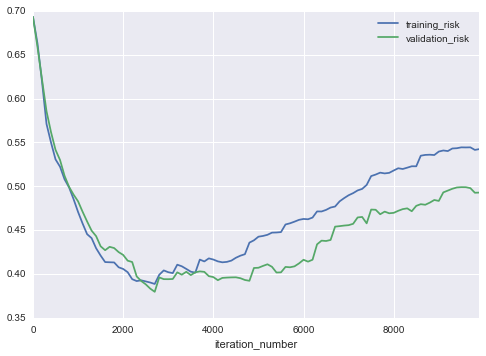

In [143]:
w, risks = qkrsgd_wrapper(stan_X, y, gamma, iters, lr)
risks.plot(x='iteration_number')

In [144]:
def lkrsgd_test(vX, vy, tX, alpha):
    val_risk = []
    for count, (xi, yi) in enumerate(zip(vX, vy)):
        fx = np.dot(alpha, (np.dot(xi, tX.T) + 1))
        z = yi * fx
        loss = np.log(1 + np.exp(z * -1))
        val_risk.append(loss)
    return np.sum(val_risk) / len(vX)

def lkrsgd_wrapper(X, y, gamma, num_iters, lr=None):
    split = int(len(X) * 2 / 3)
    tX, ty = X[:split], y[:split]
    vX, vy = X[split:], y[split:]
    print("Creating training and test sets of %i and %i" % (len(tX), len(vX)))
    alpha = np.zeros(split)
    print("Creating alphas of length: ", len(alpha))
    np.random.seed(200)
    iters = np.random.choice(split, num_iters)
    print("Creating iteration choices of length ", len(iters))
    nullLR = False
    if not lr:
        nullLR = True
        print("auto learning rate")
    else:
        print("Learning rate of ", lr)
    risks = []
    iteration_numbers = []
    val_risks = []
    epoch_risk = []
    
    kernel_gram = (tX.dot(tX.T) + 1)
    kgwy = kernel_gram.dot(np.diag(ty))
    
    for count, choice in enumerate(iters):
        if nullLR:
            lr = 0.0001 / (count/5 + 1)
        ai = alpha[choice]
        yi = ty[choice]
        update_prep = alpha.dot(kgwy)
        zi = update_prep[choice]
        if zi > 200:
            print("WARNING: LARGE Z VALUE => NOW CLAMPING")
            zi = 200
        s = lambda z: 1 / (1 + np.exp(-zi))
        update = ai - (gamma * ai) + (lr * s(zi) * ty[choice])
        alpha[choice] = update
        alpha[choice+1:] -= (alpha[choice+1:] * gamma)
        alpha[:choice] -= (alpha[:choice] * gamma)


        if count % 100 == 0:
            risk = np.sum(np.log(1 + np.exp(update_prep * -1))) / len(tX)
            iteration_numbers.append(count)
            risks.append(risk)
            epoch_risk = [] # resetting the epoch risk
            val_risks.append(qkrsgd_test(vX, vy, tX, alpha))
    return alpha, pd.DataFrame({
            "iteration_number": iteration_numbers,
            "training_risk":risks,
            "validation_risk": val_risks
        })

In [146]:
w2, risks2 = lkrsgd_wrapper(stan_X, y, gamma, iters, lr)
risks2.plot(x='iteration_number')

Creating training and test sets of 2300 and 1150
Creating alphas of length:  2300
Creating iteration choices of length  10000
Learning rate of  5e-05


KeyboardInterrupt: 